In [0]:
from zipfile import ZipFile

file_name = "/content/deu-eng.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [0]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

Using TensorFlow backend.


##Loading Data

In [0]:
# function to read raw text file
def read_text(filename):
  file = open(filename, mode='rt', encoding='utf-8')
  text = file.read()
  file.close()
  return text

In [0]:
# split a text into sentences
def to_lines(text):
  sents = text.strip().split('\n')
  sents = [i.split('\t') for i in sents]
  return sents

In [0]:
data = read_text("deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)
#deu_eng = deu_eng[:50000,:]

In [0]:
deu_eng.shape

(195847, 2)

In [0]:
deu_eng

array([['Hi.', 'Hallo!'],
       ['Hi.', 'Grüß Gott!'],
       ['Run!', 'Lauf!'],
       ...,
       ["If someone who doesn't know your background says that you sound like a native speaker, it means they probably noticed something about your speaking that made them realize you weren't a native speaker. In other words, you don't really sound like a native speaker.",
        'Wenn jemand Fremdes dir sagt, dass du dich wie ein Muttersprachler anhörst, bedeutet das wahrscheinlich: Er hat etwas an deinem Sprechen bemerkt, dass dich als Nicht-Muttersprachler verraten hat. Mit anderen Worten: Du hörst dich nicht wirklich wie ein Muttersprachler an.'],
       ['It may be impossible to get a completely error-free corpus due to the nature of this kind of collaborative effort. However, if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning, we might be able to minimize errors.',
        'Es ist wohl unmöglich, einen vollkommen 

##Text Cleaning

In [0]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [0]:
# convert text to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

##Text to Sequence Conversion

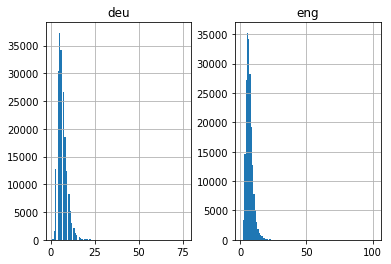

In [0]:
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 100)
plt.show()

In [0]:
length_df.sample(5)

,eng,deu
75911,6,8
176054,9,9
83662,7,6
17050,3,6
130064,5,4


In [0]:
# function to build a tokenizer
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [0]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 16172


In [0]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 35021


In [0]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

In [0]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [0]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

##Building Model

In [0]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [0]:
# model compilation
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

W0817 16:19:40.674347 140564672681856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0817 16:19:40.723821 140564672681856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0817 16:19:40.730109 140564672681856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0817 16:19:41.456930 140564672681856 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2974: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instruct

In [0]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

W0817 16:19:47.897966 140564672681856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0817 16:19:47.903947 140564672681856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3341: The name tf.log is deprecated. Please use tf.math.log instead.



In [0]:
filename = 'MT_model_1.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [0]:
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=50, batch_size=128, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

W0817 16:20:54.187448 140564672681856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 125341 samples, validate on 31336 samples
Epoch 1/50
125341/125341 [==============================] - 86s 688us/step - loss: 4.4201 - val_loss: 3.9415

Epoch 00001: val_loss improved from inf to 3.94153, saving model to MT_model_1.h5
Epoch 2/50
125341/125341 [==============================] - 81s 647us/step - loss: 3.5121 - val_loss: 3.3278

Epoch 00002: val_loss improved from 3.94153 to 3.32784, saving model to MT_model_1.h5
Epoch 3/50
125341/125341 [==============================] - 82s 651us/step - loss: 2.9921 - val_loss: 2.9610

Epoch 00003: val_loss improved from 3.32784 to 2.96097, saving model to MT_model_1.h5
Epoch 4/50
125341/125341 [==============================] - 82s 651us/step - loss: 2.6573 - val_loss: 2.7698

Epoch 00004: val_loss improved from 2.96097 to 2.76979, saving model to MT_model_1.h5
Epoch 5/50
125341/125341 [==============================] - 81s 649us/step - loss: 2.4156 - val_loss: 2.6546

Epoch 00005: val_loss improved from 2.76979 to 2.65459, sav

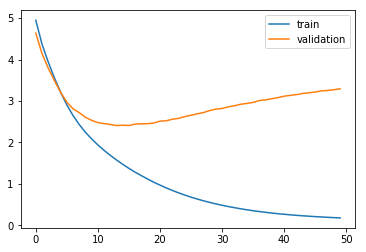

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [0]:
model = load_model('MT_model_1.h5')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [0]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [0]:
preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

In [0]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [0]:
pred_df.sample(10)

,actual,predicted
36097,do you like to watch sports on television,do like watch on in tv
4464,i think tom would make a good teacher,i think tom would make a teacher
26508,this chair is made of plastic,this chair is stop to
16870,im not laughing,i dont get
18092,that might be true,that could be true
20679,he said his name was tom,he said his name
20646,do we have any schnapps left,do we still any
9792,you said you could play the piano,you thought you could how the piano
33559,i wish it would happen more often,i wish that better
29812,is tom happy,is tom happy


In [0]:
pred_df.head()

,actual,predicted
0,i think i might buy that house on park street thats for sale,the park you to us
1,youve found a good man,you found a good
2,may i have a look at your ticket,can i take a look at you
3,tom prayed to god for help,tom asked for
4,whats the matter with you you look pale,what you find looking


In [0]:
pred_df.tail()

,actual,predicted
39165,tom told mary everything he knew about what had happened,told mary what about the worst
39166,he wants vengeance,he wants to whats math
39167,its still snowing,its is
39168,no sooner had i opened the box than a frog jumped out,i painted the box to my shoes
39169,i thought you didnt want to go,i thought you didnt want going
